In [1]:
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.util import MLUtils

In [110]:
from pyspark.ml.linalg import Vectors
#from pyspark.ml.feature import LabeledPoint
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

In [3]:
spark = SparkSession.builder.appName('Project').getOrCreate()

dataset=spark.read.csv("reviews.tbl", inferSchema = True, header = True, sep = '|')

dataset.createTempView("product_reviews")

In [4]:
q="SELECT CASE pr_rating WHEN 1 THEN '0' WHEN 2 THEN '0' WHEN 3 THEN '0' WHEN 4 THEN '1' WHEN 5 THEN '1' END AS pr_r_rating, pr_content FROM product_reviews WHERE pmod(pr_review_id, 5) IN (1,2,3)"

In [5]:
df = spark.sql(q).toDF("label", "sentence")

In [6]:
tokenizer = Tokenizer(inputCol="sentence", outputCol="words")
wordsData = tokenizer.transform(df)

In [7]:
hashingTF = HashingTF(inputCol="words",outputCol="rawFeatures")

In [8]:
featurizedData = hashingTF.transform(wordsData)

In [67]:
idf = IDF(inputCol = "rawFeatures",outputCol = "userFeatures")

In [68]:
idfModel = idf.fit(featurizedData)

In [69]:
rescaledData = idfModel.transform(featurizedData)

In [71]:

rescaledData.select("label", "sentence").show()

+-----+--------------------+
|label|            sentence|
+-----+--------------------+
|    0|attainments are; ...|
|    0|fluffily ironic e...|
|    0|dolphins about ov...|
|    0|bullshit must sub...|
|    0|silent decline or...|
|    0|bold platelets ex...|
|    0|special sustainab...|
|    1|quick winner afte...|
|    0|frays doze whitho...|
|    0|dolphins in place...|
|    0|bravely permanent...|
|    1|ruthlessly risk-f...|
|    0|best-performing d...|
|    0|orbits need to in...|
|    0|idle patience cou...|
|    0|busy deny tithes ...|
|    0|quick brave notor...|
|    0|sheaves will have...|
|    0|daringly fluffy f...|
|    0|carefully express...|
+-----+--------------------+
only showing top 20 rows



In [72]:
rescaledData.printSchema()

root
 |-- label: string (nullable = true)
 |-- sentence: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawFeatures: vector (nullable = true)
 |-- userFeatures: vector (nullable = true)



In [130]:
from pyspark.ml.linalg import DenseVector
df = rescaledData.select(rescaledData["label"].cast("double"), rescaledData["sentence"],(rescaledData["userFeatures"]))

In [133]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["userFeatures"],
    outputCol="features")

output = assembler.transform(df)
output.select("label", "sentence", "features").printSchema()

root
 |-- label: double (nullable = true)
 |-- sentence: string (nullable = true)
 |-- features: vector (nullable = true)



In [136]:
training, test = output.randomSplit([0.6, 0.4])

In [140]:
import matplotlib.pyplot as plt

[]

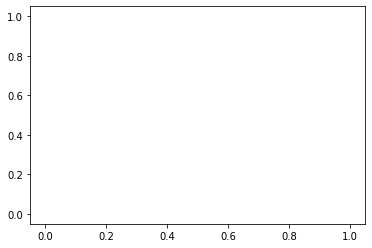

In [142]:
plt.plot(label=1.0)

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)



In [113]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [114]:
model = lr.fit(training)

In [116]:
print("Coefficients: " + str(model.coefficients))

Coefficients: (262144,[],[])


In [117]:
print("Intercept: " + str(model.intercept))

Intercept: -1.8912156181955027


In [123]:
model.summary

In [124]:
from pyspark.ml import Pipeline

In [137]:
pipeline = Pipeline(stages=[tokenizer,hashingTF,lr])

In [138]:
model_pipeline = pipeline.fit(training)

In [139]:
print(model_pipeline)

PipelineModel_fbbb4e2c7dbb


In [26]:
df.describe().show()

+-------+-------------------+
|summary|              label|
+-------+-------------------+
|  count|              24346|
|   mean|0.12954900188942742|
| stddev|  0.335813475011977|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



In [53]:
print(intercept)

0.0


In [57]:
numClasses= model.numClasses

In [58]:
print(numClasses)

2


In [36]:
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(predictionAndLabel)
confusion_matrix= metrics.confusionMatrix

In [38]:
print("Confusion matrix:")
print(confusion_matrix)

Confusion matrix:
<bound method MulticlassMetrics.confusionMatrix of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7ffa00c8f250>>


In [39]:
precisions= metrics.precision


In [40]:
print("Precision =")
print(precisions)


Precision =
<bound method MulticlassMetrics.precision of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7ffa00c8f250>>
